## Initialization

In [1]:
import unet, imageGeneration, benchmark

## Define image parameters function

In [2]:
def image_parameters_function(lower_limit_SNR, higher_limit_SNR, image_size = 256):
    from numpy.random import uniform, randint
    from numpy import ones
    from math import pi
    
    particle_number = randint(20, 30)
    particle_radius_list = uniform(0.5, 2, particle_number)
    (particle_center_x_list, particle_center_y_list) = imageGeneration.get_particle_positions(particle_radius_list, image_size)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([1, ])
        particle_intensities_list.append([uniform(0.05, 0.13, 1), ])

    image_parameters = imageGeneration.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(.3, .5),
        signal_to_noise_ratio=lambda: uniform(lower_limit_SNR, higher_limit_SNR),
        gradient_intensity=lambda: uniform(0, 0),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

## Plot distance from upper left corner as function of SNR for a given cutoff value. 
SNR values are [lower_SNR:1:higher_SNR+1]

In [3]:
def plot_distance_from_upper_left_as_function_of_SNR(model, lower_SNR, higher_SNR, cutoff_value = 0.5):
    from matplotlib import pyplot as plt
    
    distances = []
    for SNR in range(lower_SNR, higher_SNR+1):
        (batch_images, batch_labels, batch_predictions) = imageGeneration.get_batch(batch_size = 10,
                                                                                    verbose = False,
                                                                                get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
                                                                                                                                                 higher_limit_SNR = SNR+1))
        batch_predictions = model.predict(batch_images)
        batch_predictions = imageGeneration.cutoff(batch_predictions, cutoff_value = cutoff_value, apply_sigmoid = True)
        operating_characteristics = benchmark.get_operating_characteristics(batch_labels, batch_predictions)
        distances.append(benchmark.distance_from_upper_left_corner_ROC(operating_characteristics))
    plt.plot(range(lower_SNR,higher_SNR+1), distances)
    plt.ylim(0,500)
    plt.show()

## Draw ROC as function of SNR for a given cutoff value.
SNR values are [lower_SNR:1:higher_SNR+1]

In [4]:
def plot_ROC_curve_as_function_of_SNR(model, lower_SNR, higher_SNR, cutoff_value = 0.5):
    from matplotlib import pyplot as plt
    
    TPR = []
    FPR = []
    for SNR in range(lower_SNR, higher_SNR+1):
        (batch_images, batch_labels, batch_predictions) = imageGeneration.get_batch(batch_size = 10,
                                                                                    verbose = False,
                                                                                get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
                                                                                                                                                 higher_limit_SNR = SNR+1))
        batch_predictions = model.predict(batch_images)
        batch_predictions = imageGeneration.cutoff(batch_predictions, cutoff_value = cutoff_value, apply_sigmoid = True)
        P, N, TP, TN, FP, FN = benchmark.get_operating_characteristics(batch_labels, batch_predictions)
        TPR.append(TP/P)
        FPR.append(FP/N)
        
    plt.plot(FPR, TPR)
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()

## Plot distance from upper left corner as function of cutoff for a given SNR. 
SNR values are [lower_cutoff:step:higher_cutoff)

In [10]:
def plot_distance_from_upper_left_as_function_of_cutoff(model, SNR, lower_cutoff = 0.01, higher_cutoff = 1, step = 0.01, FPR_weight = 1.0, verbose = False):
    from matplotlib import pyplot as plt
    from numpy import arange
    
    batch = imageGeneration.get_batch(batch_size = 10,
                                      verbose = False,
                                      get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
                                                                                                       higher_limit_SNR = SNR+1))

    (batch_images, batch_labels, batch_predictions) = batch
    batch_predictions = model.predict(batch_images)
    
    distances = []
    
    for cutoff_value in arange(lower_cutoff, higher_cutoff, step):
        if(verbose):     
            print(cutoff_value)
        batch_predictions_cutoff = imageGeneration.cutoff(batch_predictions.copy(), cutoff_value = cutoff_value, apply_sigmoid = True)
        operating_characteristics = benchmark.get_operating_characteristics(batch_labels, batch_predictions)
        print(FPR_weight)
        distances.append(benchmark.distance_from_upper_left_corner_ROC(operating_characteristics, FPR_weight))
        
    plt.plot(arange(lower_cutoff, higher_cutoff, step), distances)

## Draw ROC as function of cutoff for a given SNR.
SNR values are [lower_cutoff:step:higher_cutoff)

In [20]:
def plot_ROC_curve_as_function_of_cutoff(model, SNR, lower_cutoff = 0.01, higher_cutoff = 1, step = 0.01, FPR_weight = 1.0, verbose = False):
    from matplotlib import pyplot as plt
    from numpy import arange
    
    batch = imageGeneration.get_batch(batch_size = 10,
                                      verbose = True,
                                      get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
                                                                                                       higher_limit_SNR = SNR+1))
    
    (batch_images, batch_labels, batch_predictions) = batch
    imageGeneration.visualise_batch(batch, use_predictions = False)
    batch_predictions = model.predict(batch_images)

    TPR = []
    FPR = []
    
    for cutoff_value in arange(lower_cutoff, higher_cutoff, step):
        if(verbose):     
            print(cutoff_value)
        batch_predictions_cutoff = imageGeneration.cutoff(batch_predictions.copy(), cutoff_value = cutoff_value, apply_sigmoid = True)
        operating_characteristics = benchmark.get_operating_characteristics(batch_labels, batch_predictions_cutoff)
        (P, N, TP, TN, FP, FN) = operating_characteristics
        print(benchmark.distance_from_upper_left_corner_ROC(operating_characteristics, FPR_weight = FPR_weight))
        TPR.append(TP/P)
        FPR.append(FPR_weight * FP/N)
        batch = (batch_images, batch_labels, batch_predictions_cutoff)
        imageGeneration.visualise_batch(batch)
        plt.show()
        
    plt.plot(FPR, TPR, 'bo')
    plt.xlim((0,1))
    plt.ylim((0,1))


## Benchmark models

In [7]:
# import glob, os
# from matplotlib import pyplot as plt
# from scipy.ndimage import zoom
# import numpy as np

# lower_limit_SNR = 15
# higher_limit_SNR = 16
# batch = imageGeneration.get_batch(batch_size = 10,
#                                   get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = lower_limit_SNR,
#                                                                                                    higher_limit_SNR = higher_limit_SNR))
# (batch_images, batch_labels, batch_predictions) = batch

# model = unet.create_unet()

# plt.imshow(zoom(batch_images[0,:,:,0],5.0), cmap = 'gray', vmin = 0, vmax = 1)
# plt.colorbar()
# plt.show()

# imageGeneration.visualise_batch((batch_images, batch_labels, batch_predictions), use_predictions = False)
# plt.show()

# for filename in glob.iglob('C:\School\Årskurs 3\Kandidat\DeepTrack\DeepTrack 1.0\\NewNetwork' + '\*\*.hdf5', recursive=True):
    
#     #Prints current filename
#     filenameList = filename.split('\\')
#     print("Filename is %s."% ('\\'.join(filenameList[len(filenameList)-2:len(filenameList)])))
    

#     TPR = []
#     FPR = []
#     TPRoverFPR = []
#     lower_SNR = 10
#     upper_SNR = 30
#     for SNR in range(lower_SNR, upper_SNR):
#         model.load_weights(filename)
#         #Generate batch for cutoff
#         (batch_images, batch_labels, batch_predictions) = imageGeneration.get_batch(batch_size = 10,
#                                                                                     get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
#                                                                                                                                              higher_limit_SNR = SNR+1),
#                                                                                     verbose = False)
#         #Generate predictions for cutoff and find optimal cutoff for current SNR
#         batch_predictions = model.predict(batch_images)
#         optimal_cutoff = unet.get_optimal_cutoff(batch_labels, batch_predictions, sample_size = 10, apply_sigmoid = True)
#         print("SNR is %d, optimal_cutoff is %.10f" % (SNR, optimal_cutoff))
        
#         #Generate batch for benchmarking
#         (batch_images, batch_labels, batch_predictions) = imageGeneration.get_batch(batch_size = 10,
#                                                                                     get_image_parameters_function = lambda:image_parameters_function(lower_limit_SNR = SNR,
#                                                                                                                                              higher_limit_SNR = SNR+1),
#                                                                                     verbose = False)
#         #Generate predictions for benchmarking
#         batch_predictions = model.predict(batch_images)
#         batch_predictions = imageGeneration.cutoff(batch_predictions, cutoff_value = optimal_cutoff, apply_sigmoid = True)

#         #Get TPR and FPR
#         P, N, TP, TN, FP, FN = benchmark.get_operating_characteristics(batch_labels, batch_predictions)
#         print("P is %d, N is %d, TP is %d, TN is %d, FP is %d, FN is %d" % (P, N, TP, TN, FP, FN))

#         TPR.append(TP/P)
#         FPR.append(FP/N)
#         TPRoverFPR.append((TP/P)/(FP/N))
        
#     # Draw ROC curve for current model
#     plt.plot(FPR,TPR)
#     plt.ylim(0,1)
#     plt.xlim(0,0.2)
#     plt.show()
    
#     # Draw TPR/FPR ratio as function of SNR for current model
#     TPRoverFPR = np.asarray(TPR)/np.asarray(FPR)
#     plt.plot(range(lower_SNR, upper_SNR), TPRoverFPR)
#     plt.ylim(0,450)
#     plt.show()
    



ASD
Time taken for batch generation of size 10: 0.12765908241271973 s.


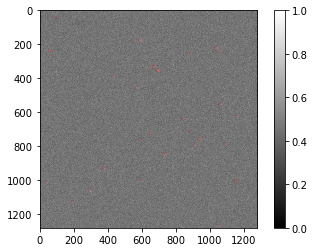

0.8
0.7498657659518704


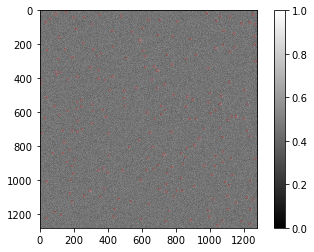

0.805
0.7403753725443403


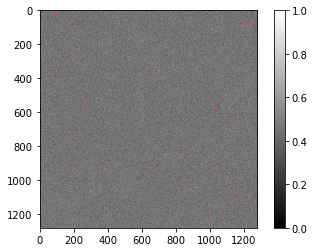

0.81
0.7293046846711485


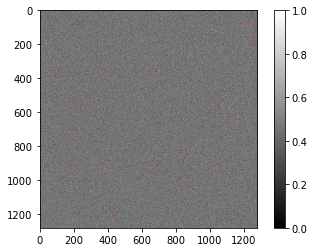

0.8150000000000001
0.7214491002718878


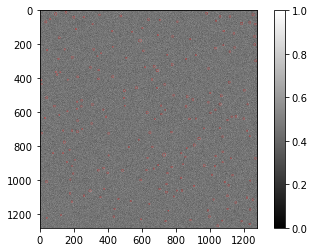

0.8200000000000001
0.7137696654995046


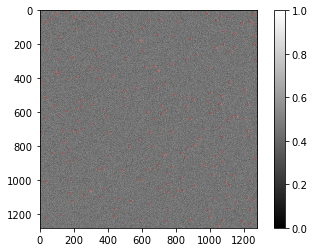

0.8250000000000001
0.7075105142006249


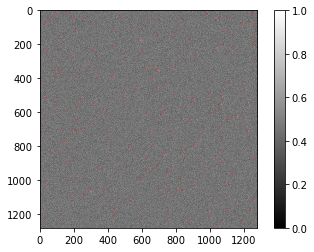

0.8300000000000001
0.6979831305397296


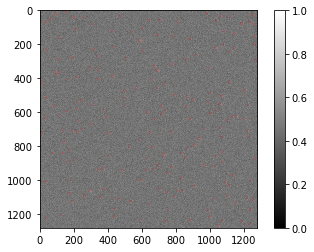

0.8350000000000001
0.6892024630085554


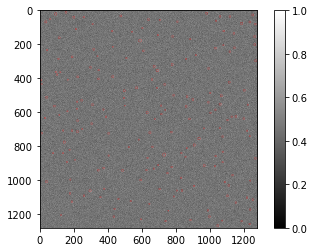

0.8400000000000001
0.6805609131327799


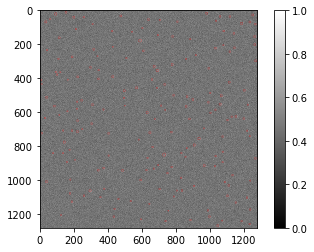

0.8450000000000001
0.6736358684582888


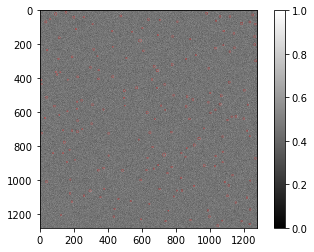

0.8500000000000001
0.6629883153980579


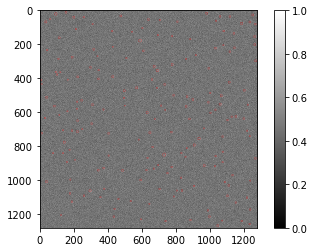

0.8550000000000001
0.6536996076589703


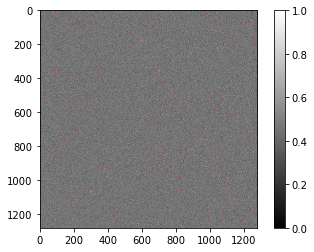

0.8600000000000001
0.6453107325989715


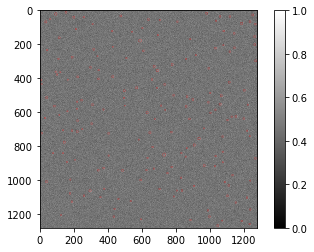

0.8650000000000001
0.6359346589388454


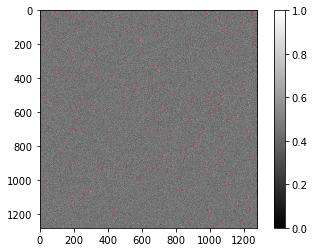

0.8700000000000001
0.6249268074144002


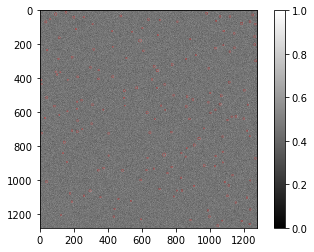

0.8750000000000001
0.6165487800803247


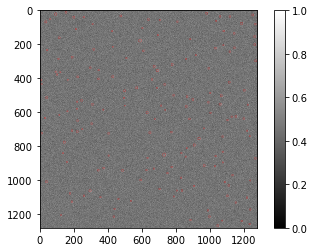

0.8800000000000001
0.6109163321027129


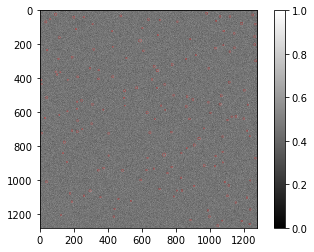

0.8850000000000001
0.6037109213334086


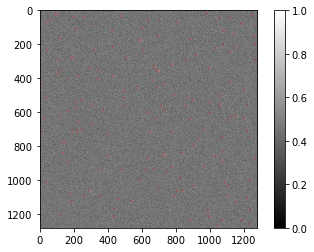

0.8900000000000001
0.5969755944970818


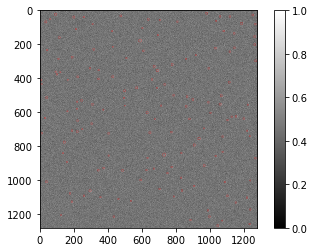

0.8950000000000001
0.5906636504993774


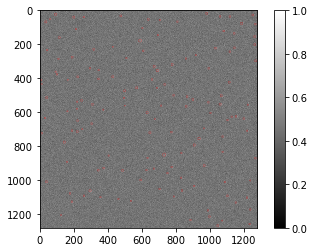

0.9000000000000001
0.5815956562321645


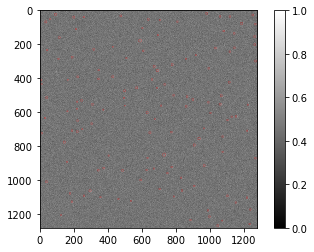

0.9050000000000001
0.576163955013986


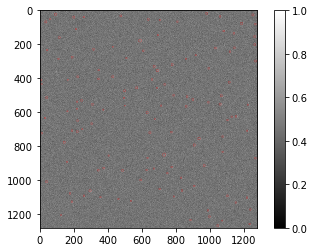

0.9100000000000001
0.5732062775014526


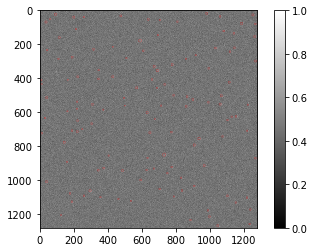

0.9150000000000001
0.5691766622623305


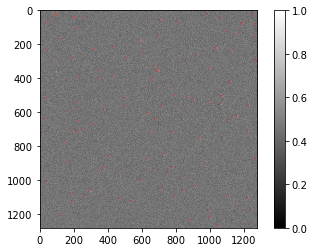

0.9200000000000002
0.5639724730292541


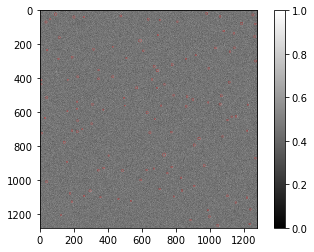

0.9250000000000002
0.5548065618994888


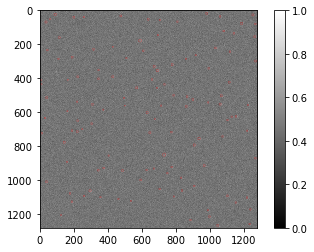

0.9300000000000002
0.5516051831547155


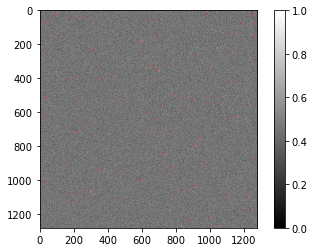

0.9350000000000002
0.5475618842678752


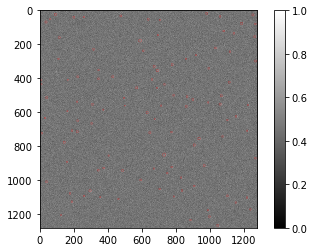

0.9400000000000002
0.5461550571467877


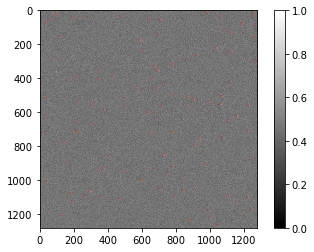

0.9450000000000002
0.5492515912528603


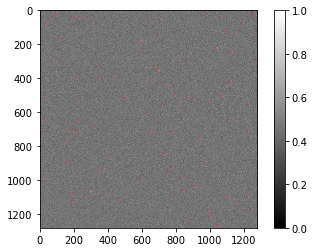

0.9500000000000002
0.5493399625200285


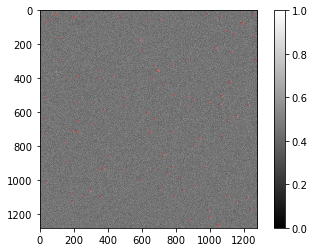

0.9550000000000002
0.5504599229058955


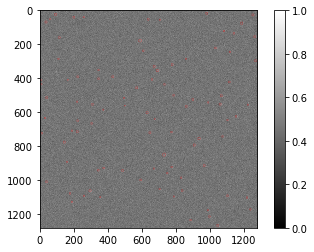

0.9600000000000002
0.5546740603749816


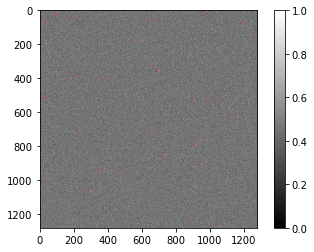

0.9650000000000002
0.55891167813034


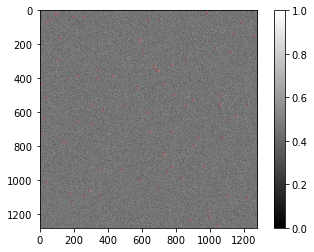

0.9700000000000002
0.5648631323184058


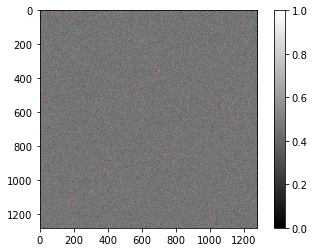

0.9750000000000002
0.5793302502362765


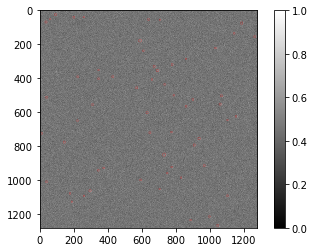

0.9800000000000002
0.5950371061923053


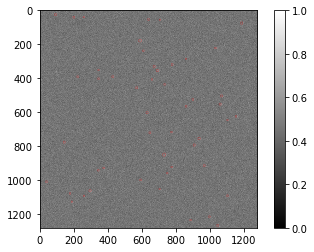

0.9850000000000002
0.6287377911767187


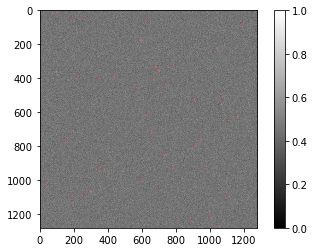

0.9900000000000002
0.6693096417809606


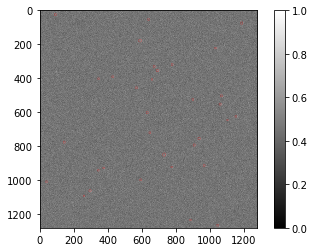

0.9950000000000002
0.7308694465892757


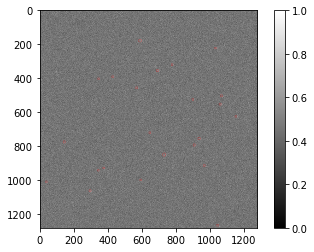

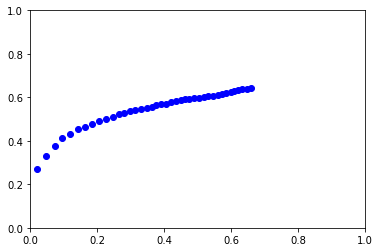

In [21]:
from matplotlib import pyplot as plt
SNR = 20
model = unet.create_unet("unet_particle.hdf5")
print("ASD")
plot_ROC_curve_as_function_of_cutoff(model, SNR, lower_cutoff = 0.8, higher_cutoff = 1, step = 0.005, verbose = True, FPR_weight = 100.0)
plt.show()